In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tqdm import tqdm
import pickle

In [ ]:
!pip install tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 97.9 MB/s  0:06:35m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 168.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 151.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 143.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 90.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 189.9 MB/s  0:00:00
  Attempting uninstall: protobuf0m━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  3/16 [wrapt]ng]
    Found existing installation: protobuf 4.23.4━━━━━━━━━━━━━━  3/16 [wrapt]
    Uninstalling protobuf-4.23.4:━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  3/16 [wrapt]
      Successfully uninstalled protobuf-4.23.4━━━━━━━━━━━━━━━━  3/16 [wrapt]
  Attempting uninstall: tensorboard━━━╺━━━━━━━━━ 12/16 [astunparse]
    Found existing installation: tensorboard 2.15.10m━━━━━━━━━ 12/16 [astunparse]
    Uninstalling tensorboard-2.15.1:0m╺━━━━━━━━━ 12/16 [astunparse]


In [ ]:
df = pd.read_csv("synthetic_load_with_missing.csv")

In [3]:
df.head()

,Unnamed: 0,hour,dayofweek,dayofyear,temp,solar,wind,load
0,2023-01-01 00:00:00,0,6,1,10.668848,-0.076225,1.738539,17.533565
1,2023-01-01 01:00:00,1,6,1,11.327964,0.532552,2.098603,NaN
2,2023-01-01 02:00:00,2,6,1,13.319822,0.521505,1.151178,10.328752
3,2023-01-01 03:00:00,3,6,1,15.230697,0.928072,2.683639,13.847641
4,2023-01-01 04:00:00,4,6,1,14.268107,1.453223,0.438029,11.776826


In [4]:
df.rename(columns={"Unnamed: 0": "Datetime"}, inplace=True)

df["Datetime"] = pd.to_datetime(df["Datetime"], errors="coerce")


In [ ]:
df = df.sort_values("Datetime")
df = df.set_index("Datetime")


In [7]:
df['load'] = df['load'].interpolate(method='time')

In [10]:
df.head()

,hour,dayofweek,dayofyear,temp,solar,wind,load
Datetime,,,,,,,
2023-01-01 00:00:00,0,6,1,10.668848,-0.076225,1.738539,17.533565
2023-01-01 01:00:00,1,6,1,11.327964,0.532552,2.098603,13.931159
2023-01-01 02:00:00,2,6,1,13.319822,0.521505,1.151178,10.328752
2023-01-01 03:00:00,3,6,1,15.230697,0.928072,2.683639,13.847641
2023-01-01 04:00:00,4,6,1,14.268107,1.453223,0.438029,11.776826


In [11]:
data = df["load"].values.reshape(-1, 1)

In [12]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [ ]:
test_days = 7
freq_per_day = 24  
test_size = test_days * freq_per_day

train_scaled = data_scaled[:-test_size]
test_scaled = data_scaled[-test_size:]

train_index = df.index[:-test_size]
test_index = df.index[-test_size:]

print(f"Train size: {len(train_scaled)}, Test size: {len(test_scaled)}")

Train size: 17352, Test size: 168


In [ ]:
window_size = 24

def create_dataset(series, window):
    X, y = [], []
    for i in range(window, len(series)):
        X.append(series[i-window:i])
        y.append(series[i])
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train_scaled, window_size)
X_test, y_test   = create_dataset(test_scaled, window_size)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test  = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [15]:
y_test

array([[0.20810015],
       [0.18606336],
       [0.14135572],
       [0.12854743],
       [0.14261644],
       [0.15668545],
       [0.16882835],
       [0.23826576],
       [0.34857585],
       [0.33458884],
       [0.38321088],
       [0.46164185],
       [0.48592231],
       [0.53658699],
       [0.5785022 ],
       [0.55109489],
       [0.55326728],
       [0.52906464],
       [0.504862  ],
       [0.43214567],
       [0.42553655],
       [0.33143146],
       [0.31628353],
       [0.21488995],
       [0.22103137],
       [0.16309537],
       [0.08619318],
       [0.19862008],
       [0.12613319],
       [0.13947422],
       [0.18163145],
       [0.25689188],
       [0.28942768],
       [0.36369251],
       [0.39355076],
       [0.48844596],
       [0.57100801],
       [0.55290159],
       [0.61174998],
       [0.54479805],
       [0.55015362],
       [0.51851352],
       [0.58922933],
       [0.45163328],
       [0.38978146],
       [0.34510688],
       [0.29338297],
       [0.225

In [16]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(window_size, 1)),
    LSTM(32),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.0176
Epoch 2/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.0018
Epoch 3/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.0016
Epoch 4/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.0016
Epoch 5/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.0016
Epoch 6/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.0015
Epoch 7/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - loss: 0.0015
Epoch 8/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - loss: 0.0015
Epoch 9/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - loss: 0.0015
Epoch 10/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.0014
Epoch 11/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.0015
Epoch 12/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.0015
Epoch 13/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.0015
Epoch 14/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.0015
Epoch 15/20
542/542 ━━━━━━━━━

In [17]:
pred_scaled = model.predict(X_test)

pred   = scaler.inverse_transform(pred_scaled)
actual = scaler.inverse_transform(y_test)

pred_1d = pred.ravel()
actual_1d = actual.ravel()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step


In [18]:
test_index_aligned = test_index[-len(y_test):]


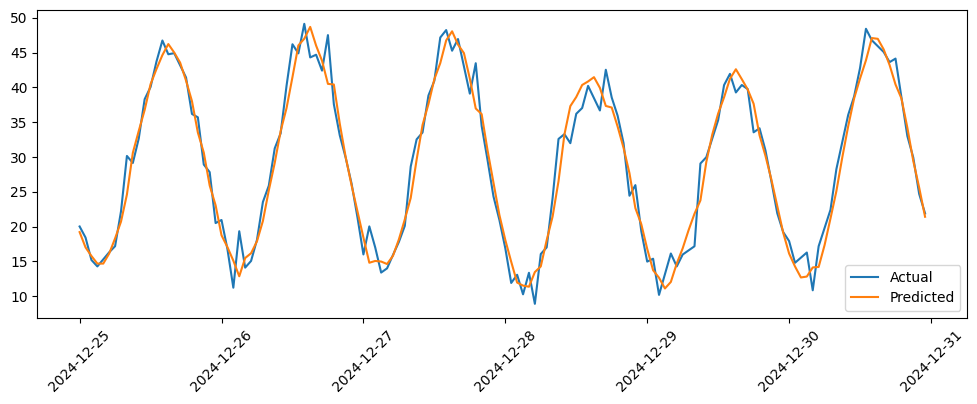

In [19]:
plt.figure(figsize=(12,4))
plt.plot(test_index_aligned, actual_1d, label="Actual")
plt.plot(test_index_aligned, pred_1d, label="Predicted")
plt.legend()
plt.xticks(rotation=45)
plt.show()


In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [21]:
mae = mean_absolute_error(actual, pred)
rmse = np.sqrt(mean_squared_error(actual, pred))
mape = np.mean(np.abs((actual - pred) / actual)) * 100

print("\n=== LSTM PERFORMANCE ON LAST 7 DAYS ===")
print(f"MAE  : {mae}")
print(f"RMSE : {rmse}")
print(f"MAPE : {mape} %")


=== LSTM PERFORMANCE ON LAST 7 DAYS ===
MAE  : 1.9143077536594804
RMSE : 2.462423513838058
MAPE : 7.930099299855836 %


In [ ]:
result = pd.DataFrame({
    "Timestamp": test_index_aligned,
    "Actual": actual_1d,
    "Predicted": pred_1d
})

result.to_csv("last_7_days_predictions.csv", index=False)

print("Saved: last_7_days_predictions.csv")

Saved: last_7_days_predictions.csv


In [ ]:
import pickle


with open("load_forecast_model.pkl", "wb") as f:
    pickle.dump(model, f)

print("Model saved as load_forecast_model.pkl")

Model saved as load_forecast_model.pkl


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━

/tmp/ipython-input-455132365.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_index = pd.date_range(start=test_index[-1] + pd.Timedelta(hours=1),


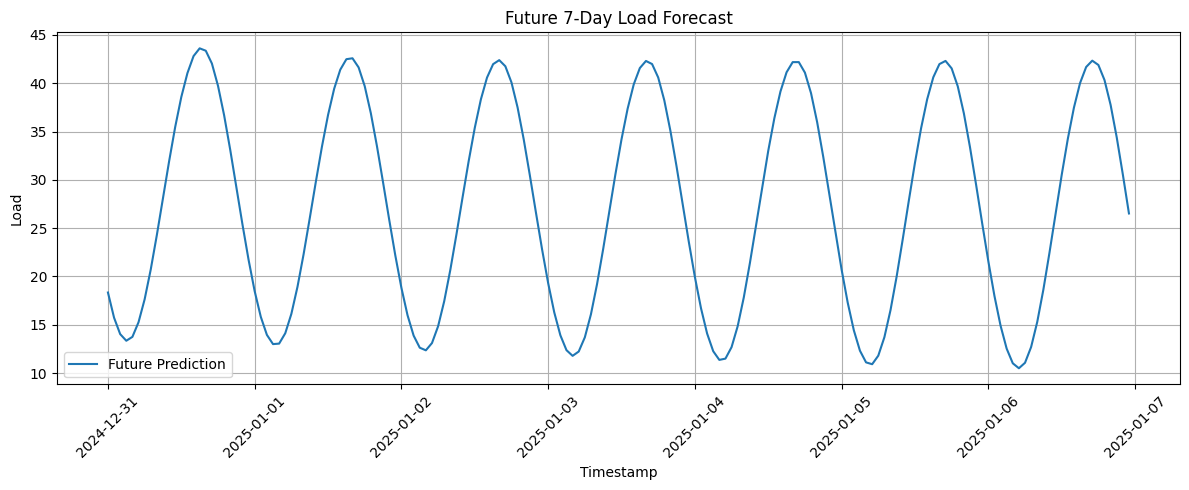


Sample Future Predictions:
            Timestamp  Predicted_Load
0 2024-12-31 00:00:00       18.332289
1 2024-12-31 01:00:00       15.724854
2 2024-12-31 02:00:00       14.027297
3 2024-12-31 03:00:00       13.339501
4 2024-12-31 04:00:00       13.741199
5 2024-12-31 05:00:00       15.254231
6 2024-12-31 06:00:00       17.627501
7 2024-12-31 07:00:00       20.721598
8 2024-12-31 08:00:00       24.291937
9 2024-12-31 09:00:00       28.097281


In [ ]:
future_hours = 7 * 24

last_sequence = test_scaled[-window_size:].reshape(1, window_size, 1)

future_predictions_scaled = []

for i in range(future_hours):
    next_pred_scaled = model.predict(last_sequence)[0]
    future_predictions_scaled.append(next_pred_scaled)

    last_sequence = np.append(last_sequence[:, 1:, :], [[next_pred_scaled]], axis=1)

future_predictions_scaled = np.array(future_predictions_scaled)

future_predictions = scaler.inverse_transform(future_predictions_scaled)

future_index = pd.date_range(start=test_index[-1] + pd.Timedelta(hours=1),
                             periods=future_hours,
                             freq="H")

plt.figure(figsize=(12,5))
plt.plot(future_index, future_predictions, label="Future Prediction")
plt.title("Future 7-Day Load Forecast")
plt.xlabel("Timestamp")
plt.ylabel("Load")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nSample Future Predictions:")
print(pd.DataFrame({
    "Timestamp": future_index[:10],
    "Predicted_Load": future_predictions[:10].flatten()
}))


In [25]:
import pickle
pickle.dump(scaler, open("scaler.pkl", "wb"))
print("Scaler saved as scaler.pkl")

Scaler saved as scaler.pkl
